# **Constructive Hyper Heuristic for TSP Problem**

In [488]:
import xml.etree.ElementTree as ET
import numpy as np
import random
import time

# Load the XML file
tree = ET.parse('datasets/data.xml')
root = tree.getroot()

# Initialize the distance matrix
number_of_cities = 17
distance_matrix = np.zeros((number_of_cities, number_of_cities))

# Fill the distance matrix
for i, vertex in enumerate(root.find('graph').findall('vertex')):
    for edge in vertex.findall('edge'):
        j = int(edge.text)  # The index of the destination city
        cost = float(edge.get('cost'))  # The cost to travel to this city
        distance_matrix[i, j] = cost

# **Hyper heuristic 1  :**   
# **High Level Strategy :** GRASP  
# **Low Level Staretgy :** Nearest Neighbor, Nearest Insertion, Random Insertion
The GRASP (Greedy Randomized Adaptive Search Procedure) algorithm is an optimization method that combines greedy solutions with random elements to explore different possible solutions and uses local search to improve the solutions found.

# Selection of Heuristics
In the code, heuristic selection is performed using a roulette wheel selection method, weighted by the heuristic scores, which are updated adaptively.

**Roulette Wheel Selection**:
   - Heuristics are probabilistically selected based on their scores.
   - Heuristics with higher scores have a greater chance of being selected.



In [489]:
# Function to calculate the total distance of a tour
def calculate_tour_length(tour, distance_matrix):
    return sum(distance_matrix[tour[i], tour[i+1]] for i in range(len(tour) - 1)) + distance_matrix[tour[-1], tour[0]]


Insertion Algorithms: 

**Nearest Neighbor:** Returns the nearest city from the current city

In [490]:
# Function that calculates the nearest neighbor of a given city
def nearest_neighbor(current_city, remaining_cities, distance_matrix):
    nearest_city = min(remaining_cities, key=lambda city: distance_matrix[current_city, city])
    return nearest_city


**Nearest Insertion :** Returns the city that, when inserted between two given cities or at the end of the path, results in the minimal increase in total distance.

In [491]:
def nearest_insertion(current_solution, remaining_cities, distance_matrix):
    best_distance = float('inf')
    best_city = None

    # Iterate through all remaining cities
    for city in remaining_cities:
        # Try inserting the city between each pair of cities in the current solution
        for i in range(len(current_solution)):
            j = (i + 1) % len(current_solution)
            # Calculate the increase in distance if the city is inserted between current_solution[i] and current_solution[j]
            distance = (distance_matrix[current_solution[i], city] +
                        distance_matrix[city, current_solution[j]] -
                        distance_matrix[current_solution[i], current_solution[j]])
            # If this insertion gives a better (smaller) increase in distance
            if distance < best_distance:
                best_distance = distance
                best_city = city

    return best_city

**Random Insertion:** Returns a random city to be placed in a random position in the current solution

In [492]:
def random_insertion(current_solution, remaining_cities):
    city = random.choice(list(remaining_cities))
    position = random.randint(0, len(current_solution))
    return city, position

**evaluate_heuristic** :The function evaluates a given heuristic based on the current state of the tour, the remaining cities, and the distance matrix. Depending on the specified heuristic, it selects a new city to add to the tour using the corresponding heuristic, updates the state of the tour accordingly, calculates the total cost of the new tour, and returns this cost.

The heuristics are evaluated in terms of cost.

In [493]:
def evaluate_heuristic(heuristic, state, remaining_cities):
    if heuristic == 'nearest_neighbor':
        new_city = nearest_neighbor(state[-1], remaining_cities, distance_matrix)
        state.append(new_city)
    elif heuristic == 'nearest_insertion':
        new_city = nearest_insertion(state, remaining_cities, distance_matrix)
        state.append(new_city)
    elif heuristic == 'random_insertion':
        new_city, position = random_insertion(state, remaining_cities)
        state.insert(position, new_city)
    
    remaining_cities.remove(new_city) # Remove the new city from the list of remaining cities to visit
    new_cost = calculate_tour_length(state, distance_matrix)
    
    return new_cost


**select_heuristic:** Dynamically chooses a heuristic from a given set using a Roulette Wheel Selection method, weighted by heuristic scores.

In [494]:
def select_heuristic(state, heuristics, remaining_cities, heuristic_scores):
    candidates = []  # List to store candidates (heuristic, quality)

    # Evaluate each heuristic and add its score to the candidates list
    for heuristic in heuristics:
        quality = evaluate_heuristic(heuristic, state.copy(), remaining_cities.copy())  # Evaluate the heuristic
        candidates.append((heuristic, quality))  # Add the heuristic and its quality to the candidates list
    
    # Roulette Wheel Selection based on heuristic scores
    total_score = sum(heuristic_scores[heuristic] for heuristic, _ in candidates)  # Calculate the total heuristic scores
    pick = random.uniform(0, total_score)  # Select a random point on the roulette wheel
    current = 0  # Initialize variable to track cumulative score

    # Iterate through candidates and select the corresponding heuristic based on cumulative score
    for heuristic, _ in candidates:
        current += heuristic_scores[heuristic]  # Add current heuristic score to cumulative score
        if current > pick:  # If cumulative score exceeds the selected point
            return heuristic  # Return the corresponding heuristic

We have added the **local_search** function to perform a local search to improve the quality of the solution by swapping the positions of two cities in the tour, if it results in a reduction of the total tour cost.

In [495]:
def local_search(state, distance_matrix):
    best_cost = calculate_tour_length(state, distance_matrix)  # Calculate the initial tour cost
    best_state = state[:]  # Initialize the best solution as the initial tour state
    
    improved = True  # Variable to track if an improvement in the solution has been found
    while improved:
        improved = False  # Initialize improvement as not found for this iteration
        for i in range(1, len(state) - 2):  # Iterate through tour indices (excluding first and last)
            for j in range(i + 1, len(state) - 1):  # Iterate through subsequent indices in the tour
                if j - i == 1: continue  # Avoid swapping adjacent cities (no improvement possible)
                new_state = state[:]  # Copy the current tour state
                new_state[i:j] = reversed(state[i:j])  # Reverse the order of cities between indices i and j
                new_cost = calculate_tour_length(new_state, distance_matrix)  # Calculate the cost of the new tour
                if new_cost < best_cost:  # If the new solution is better than the current best solution
                    best_cost = new_cost  # Update the best cost
                    best_state = new_state[:]  # Update the best solution
                    improved = True  # Indicate that an improvement has been found

    return best_state  # Return the best solution found after local search


The **grasp** function implements the GRASP (Greedy Randomized Adaptive Search Procedure) algorithm to solve a Traveling Salesman Problem (TSP). It uses multiple heuristics to construct a solution, dynamically adjusts heuristic scores based on their performance, and refines the solution with local search.

In [496]:
def grasp(number_of_cities):
    heuristics = ['nearest_neighbor', 'nearest_insertion',  'random_insertion']
    heuristic_scores = {heuristic: 1 for heuristic in heuristics}  # Initialize heuristic scores to 1
    alpha = 0.3  # Learning rate for updating heuristic scores
    
    best_solution = None
    best_cost = float('inf')
    
    # Perform multiple iterations of GRASP
    for iteration in range(100):  # Number of GRASP iterations
        state = [0]
        unvisited = set(range(1, number_of_cities))
        
        # Construct the solution
        while unvisited:
            heuristic = select_heuristic(state, heuristics, unvisited, heuristic_scores)
            new_cost = evaluate_heuristic(heuristic, state, unvisited)
            # Update the heuristic score based on the new cost
            heuristic_scores[heuristic] = (1 - alpha) * heuristic_scores[heuristic] + alpha * new_cost
        
        # Improve the constructed solution using local search
        state = local_search(state, distance_matrix)
        current_cost = calculate_tour_length(state, distance_matrix)
        
        # Update the best found solution
        if current_cost < best_cost:
            best_cost = current_cost
            best_solution = state
    
    return best_solution, best_cost


Testing on datasets while evaluating the cost and time

In [498]:
# Main execution
start_time = time.time()
best_path, best_distance = grasp(number_of_cities)
end_time = time.time()

print("Best path found:", best_path)
print("Distance of the best path:", best_distance)
print("Execution time:", end_time - start_time, "seconds")


Best path found: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
Distance of the best path: 223.0
Execution time: 0.1882948875427246 seconds


**Analysis of Solution 1 Results:**

**Why choose these low-level heuristics?**
- The heuristics NN (Nearest Neighbor), nearest insertion and random insertion are chosen because they offer a balanced trade-off between speed and solution quality.
  - **Nearest Neighbor**, by selecting the nearest city at each step, is very fast and provides initial solutions quickly but may not always find the most optimal solutions in terms of total cost.
  - **Nearest insertion**, slightly slower, improves solutions by strategically inserting cities to reduce overall distances.
  - **Random insertion** introduces diversity by generating varied solutions, thereby avoiding getting stuck in local minima. Together, these heuristics provide a good balance between computational efficiency and solution quality, making the GRASP algorithm robust and effective for solving complex Traveling Salesman Problems (TSP).

- Here is a table showing execution times and costs for a set of 16 instances of the TSP using the hyperheuristic HH1 (with GRASP):
 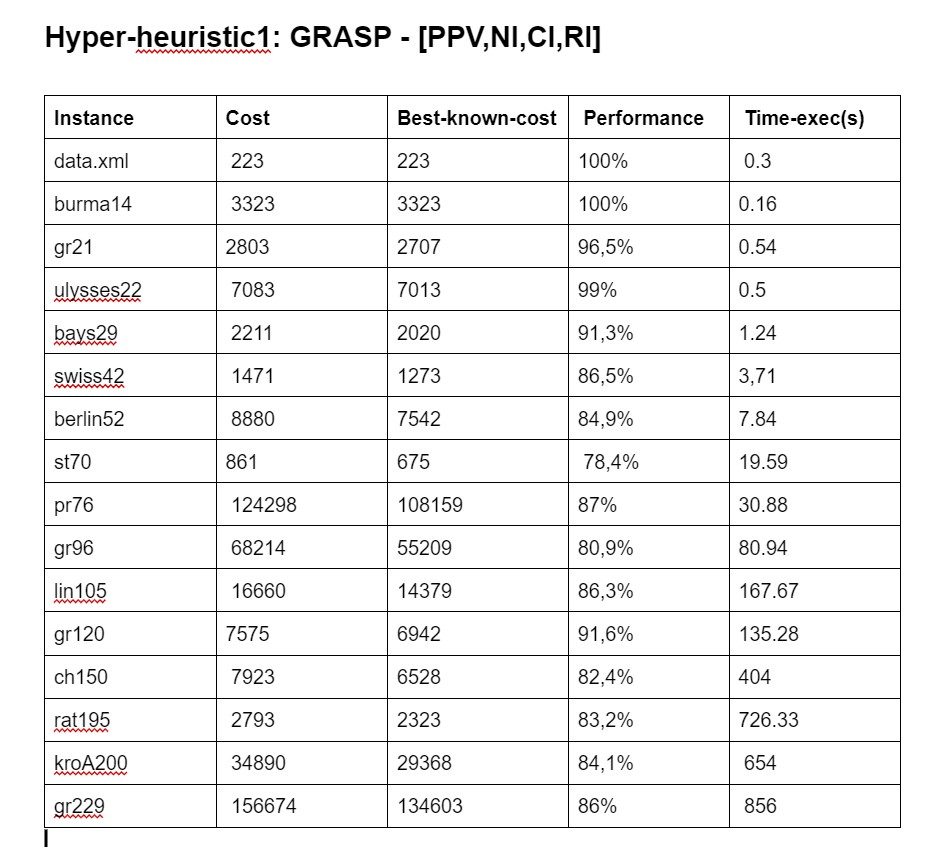

The results presented for the GRASP algorithm combined with low-level constructive heuristics (Nearest Neighbor (NN), Nearest Insertion (NI) and Random Insertion (RI)) show varied performance depending on the instances of the Traveling Salesman Problem (TSP). For smaller instances like "data.xml" and "burma14", the algorithm achieves the known optimal cost with 100% performance in very short execution times (0.3s and 0.16s respectively). As the size of instances increases, there is a gradual decrease in performance, as seen in "berlin52" (84.9%) and "gr96" (80.9%), with increasing execution times (7.84s and 80.94s). Larger instances such as "rat195" and "kroA200" exhibit reduced performances (83.2% and 84.1%) and very high execution times (726.33s and 654s). This suggests that the combination of these constructive heuristics provides solutions close to optimal for medium-sized problems with reasonable computation times, but efficiency and effectiveness diminish for larger instances, where the algorithm takes significantly longer.

# **General Conclusion** 
The performance evaluation of the GRASP algorithm in conjunction with low-level constructive heuristics highlights its effectiveness across a range of TSP instances. For small to medium-sized problems, GRASP consistently achieves near-optimal solutions with minimal computational overhead, making it ideal for real-time applications where speed and accuracy are crucial.

While larger instances show a gradual decline in performance efficiency, GRASP maintains competitiveness by leveraging its adaptive search capabilities. By intelligently combining greedy selection with randomized elements, GRASP navigates complex solution spaces, mitigates local optima traps, and provides robust solutions that balance quality and computational effort.

Furthermore, the flexibility of GRASP in integrating various low-level heuristics like Nearest Neighbor and Nearest Insertion underscores its adaptability to different problem structures. This versatility ensures that GRASP remains a versatile and reliable choice for tackling optimization problems where finding globally optimal solutions is challenging.

----------------------------------------------------------------------------------